In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
npz_path = r'F:\treadmill_gaze_control\recordings\230306_DMM_DMM001_eyecams\R01\230306_DMM001_R01_s2pData.npz'
npz_data = np.load(npz_path, allow_pickle=True)

In [4]:
data = {
    'stat': npz_data['stat'],
    'ops': npz_data['ops'].item(),
    'F': npz_data['F'],
    'Fneu': npz_data['Fneu'],
    'iscell': npz_data['iscell'],
    'spks': npz_data['spks']
}

In [3]:
list(data.keys())

NameError: name 'data' is not defined

In [5]:
def calcF0(F):
    _hist, _bins = np.histogram(F, bins=200)
    _F0 = _bins[np.nanargmax(_hist)]
    return _F0

In [6]:
inds = np.arange(np.size(data['iscell'],0))
goodcells = inds[data['iscell'][:,0]==1]

data['F0'] = np.zeros(len(inds))*np.nan
data['SignalToNoise'] = np.zeros(np.shape(data['F']))*np.nan
for n in inds:
    _F0 = calcF0(data['F'][n,:].copy())
    data['F0'][n] = _F0
    data['SignalToNoise'][n,:] = data['F'][n,:].copy() / _F0


C:\Users\dmartins\AppData\Local\Temp\ipykernel_31756\4255308026.py:9: RuntimeWarning: invalid value encountered in divide
  data['SignalToNoise'][n,:] = data['F'][n,:].copy() / _F0


In [7]:

cellstats = {
    'prob': np.zeros(len(inds))*np.nan,
    'rad': np.zeros(len(inds))*np.nan,
    'aspect': np.zeros(len(inds))*np.nan,
    'cmpt': np.zeros(len(inds))*np.nan,
    'std': np.zeros(len(inds))*np.nan,
    'ovrlap': np.zeros(len(inds))*np.nan,
    'meanSNR': np.zeros(len(inds))*np.nan,
    'label': np.zeros(len(inds))*np.nan,
    'F0': np.zeros(len(inds))*np.nan,
}

data['Fsub'] = np.empty(data['F'].shape)*np.nan

for n in tqdm(inds):
    cellstats['prob'][n] = data['iscell'][n][1]
    cellstats['rad'][n] = data['stat'][n]['radius']
    cellstats['aspect'][n] = data['stat'][n]['aspect_ratio']
    cellstats['cmpt'][n] = (1/data['stat'][n]['compact'])*100
    cellstats['std'][n] = data['stat'][n]['std']
    cellstats['ovrlap'][n] = np.sum(data['stat'][n]['overlap']) / len(data['stat'][n]['overlap'])
    cellstats['meanSNR'][n] = np.nanmean(data['SignalToNoise'][n,:])


  0%|          | 0/3355 [00:00<?, ?it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_31756\2148915106.py:22: RuntimeWarning: Mean of empty slice
  cellstats['meanSNR'][n] = np.nanmean(data['SignalToNoise'][n,:])
100%|██████████| 3355/3355 [00:00<00:00, 38134.58it/s]


In [83]:
normF = np.zeros(np.shape(data['F']))
rawDFF = np.zeros(np.shape(data['F']))
DFF = np.zeros(np.shape(data['F']))

for n in tqdm(inds):

    # calculate dF/F
    _rawF = data['F'][n,:].copy()
    _rawFneu = data['Fneu'][n,:].copy()
    _F0 = data['F0'][n]

    # raw DF/F
    rawDFF[n,:] = (_rawF - _F0) / _F0 * 100 

    # subtract neuropil
    r = 0.7
    _normF = _rawF - r * _rawFneu + r * np.nanmean(_rawFneu)

    DFF[n,:] = (_normF - _F0) / _F0 * 100
    normF[n,:] = _normF

data['rawDFF'] = rawDFF
data['DFF'] = DFF
data['normF'] = normF

 50%|████▉     | 1669/3355 [00:00<00:00, 16524.82it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_31756\1854378514.py:13: RuntimeWarning: invalid value encountered in divide
  rawDFF[n,:] = (_rawF - _F0) / _F0 * 100
C:\Users\dmartins\AppData\Local\Temp\ipykernel_31756\1854378514.py:19: RuntimeWarning: divide by zero encountered in divide
  DFF[n,:] = (_normF - _F0) / _F0 * 100
100%|██████████| 3355/3355 [00:00<00:00, 16944.29it/s]


In [84]:
prob_thresh = 0.75
snr_thresh = 1.
aspect_thresh = 1.2
cmpt_thresh = 95.
std_thresh = 100.

threshcells_bool = data['iscell'][:,0]==1
threshcells_bool[cellstats['prob']<prob_thresh] = 0
threshcells_bool[cellstats['meanSNR']<snr_thresh] = 0
threshcells_bool[cellstats['aspect']>aspect_thresh] = 0
threshcells_bool[cellstats['cmpt']<cmpt_thresh] = 0
threshcells_bool[cellstats['std']>std_thresh] = 0

threshcells = inds[threshcells_bool]

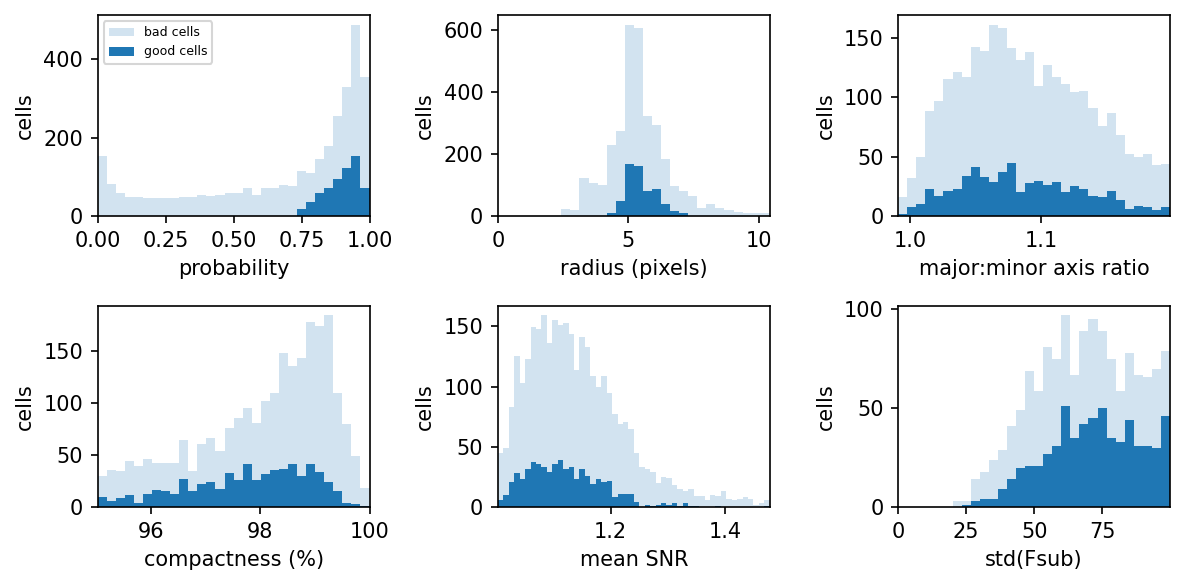

In [85]:
fig, [[prop1,prop2,prop3],[prop4,prop5,prop6]] = plt.subplots(2,3, figsize=(8,4), dpi=150)

cell_id = 0

prop1.hist(cellstats['prob'], bins=np.linspace(0,1,31),
        histtype='stepfilled', color='tab:blue', linewidth=1,
        alpha=0.2, label='bad cells')
h, _, _ = prop1.hist(cellstats['prob'][threshcells], bins=np.linspace(0,1,31),
        histtype='stepfilled', color='tab:blue', linewidth=1,
        label='good cells')
# prop1.vlines(cellstats['prob'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#         label='cell {}'.format(cell_id))
prop1.legend(fontsize=6, loc='upper left')
prop1.set_xlim([0,1])
prop1.set_xlabel('probability')
prop1.set_ylabel('cells')

_usemax = np.max(cellstats['rad'][threshcells])+3
prop2.hist(cellstats['rad'], bins=np.linspace(0,_usemax,31),
        histtype='stepfilled', color='tab:blue', linewidth=1,
        alpha=0.2, label='bad cells')
h, _, _ = prop2.hist(cellstats['rad'][threshcells], bins=np.linspace(0,_usemax,31),
            histtype='stepfilled', color='tab:blue', linewidth=1, label='good cells')
# prop2.vlines(cellstats['rad'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#         label='cell {}'.format(cell_id))
prop2.set_xlim([0, _usemax])
prop2.set_ylabel('cells')
prop2.set_xlabel('radius (pixels)')

_usemin = np.min(cellstats['aspect'][threshcells])
_usemax = np.max(cellstats['aspect'][threshcells])
prop3.hist(cellstats['aspect'], bins=np.linspace(_usemin,_usemax,31),
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells',
            histtype='stepfilled')
h, _, _ = prop3.hist(cellstats['aspect'][threshcells], bins=np.linspace(_usemin,_usemax,31),
            color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop3.vlines(cellstats['aspect'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#             label='cell {}'.format(cell_id))
prop3.set_xlim([_usemin, _usemax])
prop3.set_ylabel('cells')
prop3.set_xlabel('major:minor axis ratio')

_usemin = np.min(cellstats['cmpt'][threshcells])
prop4.hist(cellstats['cmpt'], bins=np.linspace(_usemin,100,31), histtype='stepfilled',
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells')
h, _, _ = prop4.hist(cellstats['cmpt'][threshcells], bins=np.linspace(_usemin,100,31),
                    color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop4.vlines(cellstats['cmpt'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#             label='cell {}'.format(cell_id))
prop4.set_xlim([_usemin, 100])
prop4.set_ylabel('cells')
prop4.set_xlabel('compactness (%)')

_usemin = np.nanmin(cellstats['meanSNR'][threshcells])
_usemax = np.nanmax(cellstats['meanSNR'][threshcells])
prop5.hist(cellstats['meanSNR'], bins=np.linspace(_usemin,_usemax,51),
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells',
            histtype='stepfilled')
h, _, _ = prop5.hist(cellstats['meanSNR'][threshcells], bins=np.linspace(_usemin,_usemax,51),
            color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop5.vlines(cellstats['snr'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#                 label='cell {}'.format(cell_id))
prop5.set_xlim([_usemin, _usemax])
prop5.set_ylabel('cells')
prop5.set_xlabel('mean SNR')

_usemax = np.max(cellstats['std'][threshcells])
prop6.hist(cellstats['std'], bins=np.linspace(0,_usemax,31),
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells',
            histtype='stepfilled')
h, _, _ = prop6.hist(cellstats['std'][threshcells], bins=np.linspace(0,_usemax,31),
            color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop6.vlines(cellstats['std'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#                 label='cell {}'.format(cell_id))
prop6.set_xlim([0, _usemax])
prop6.set_ylabel('cells')
prop6.set_xlabel('std(Fsub)')

fig.tight_layout()

In [86]:
print('{}/{} cells are still included ({:.3}%)'.format(
    np.sum(threshcells_bool),
    len(threshcells_bool),
    np.sum(threshcells_bool)/len(threshcells_bool)*100))

628/3355 cells are still included (18.7%)


In [87]:
meanim = data['ops']['meanImg'].copy()
cell_mask = np.zeros(meanim.shape)

for n in tqdm(threshcells):
    xy = np.stack([data['stat'][n]['xpix'], data['stat'][n]['ypix']])
    cell_mask[xy[1,:], xy[0,:]] = 1

100%|██████████| 628/628 [00:00<00:00, 104720.03it/s]


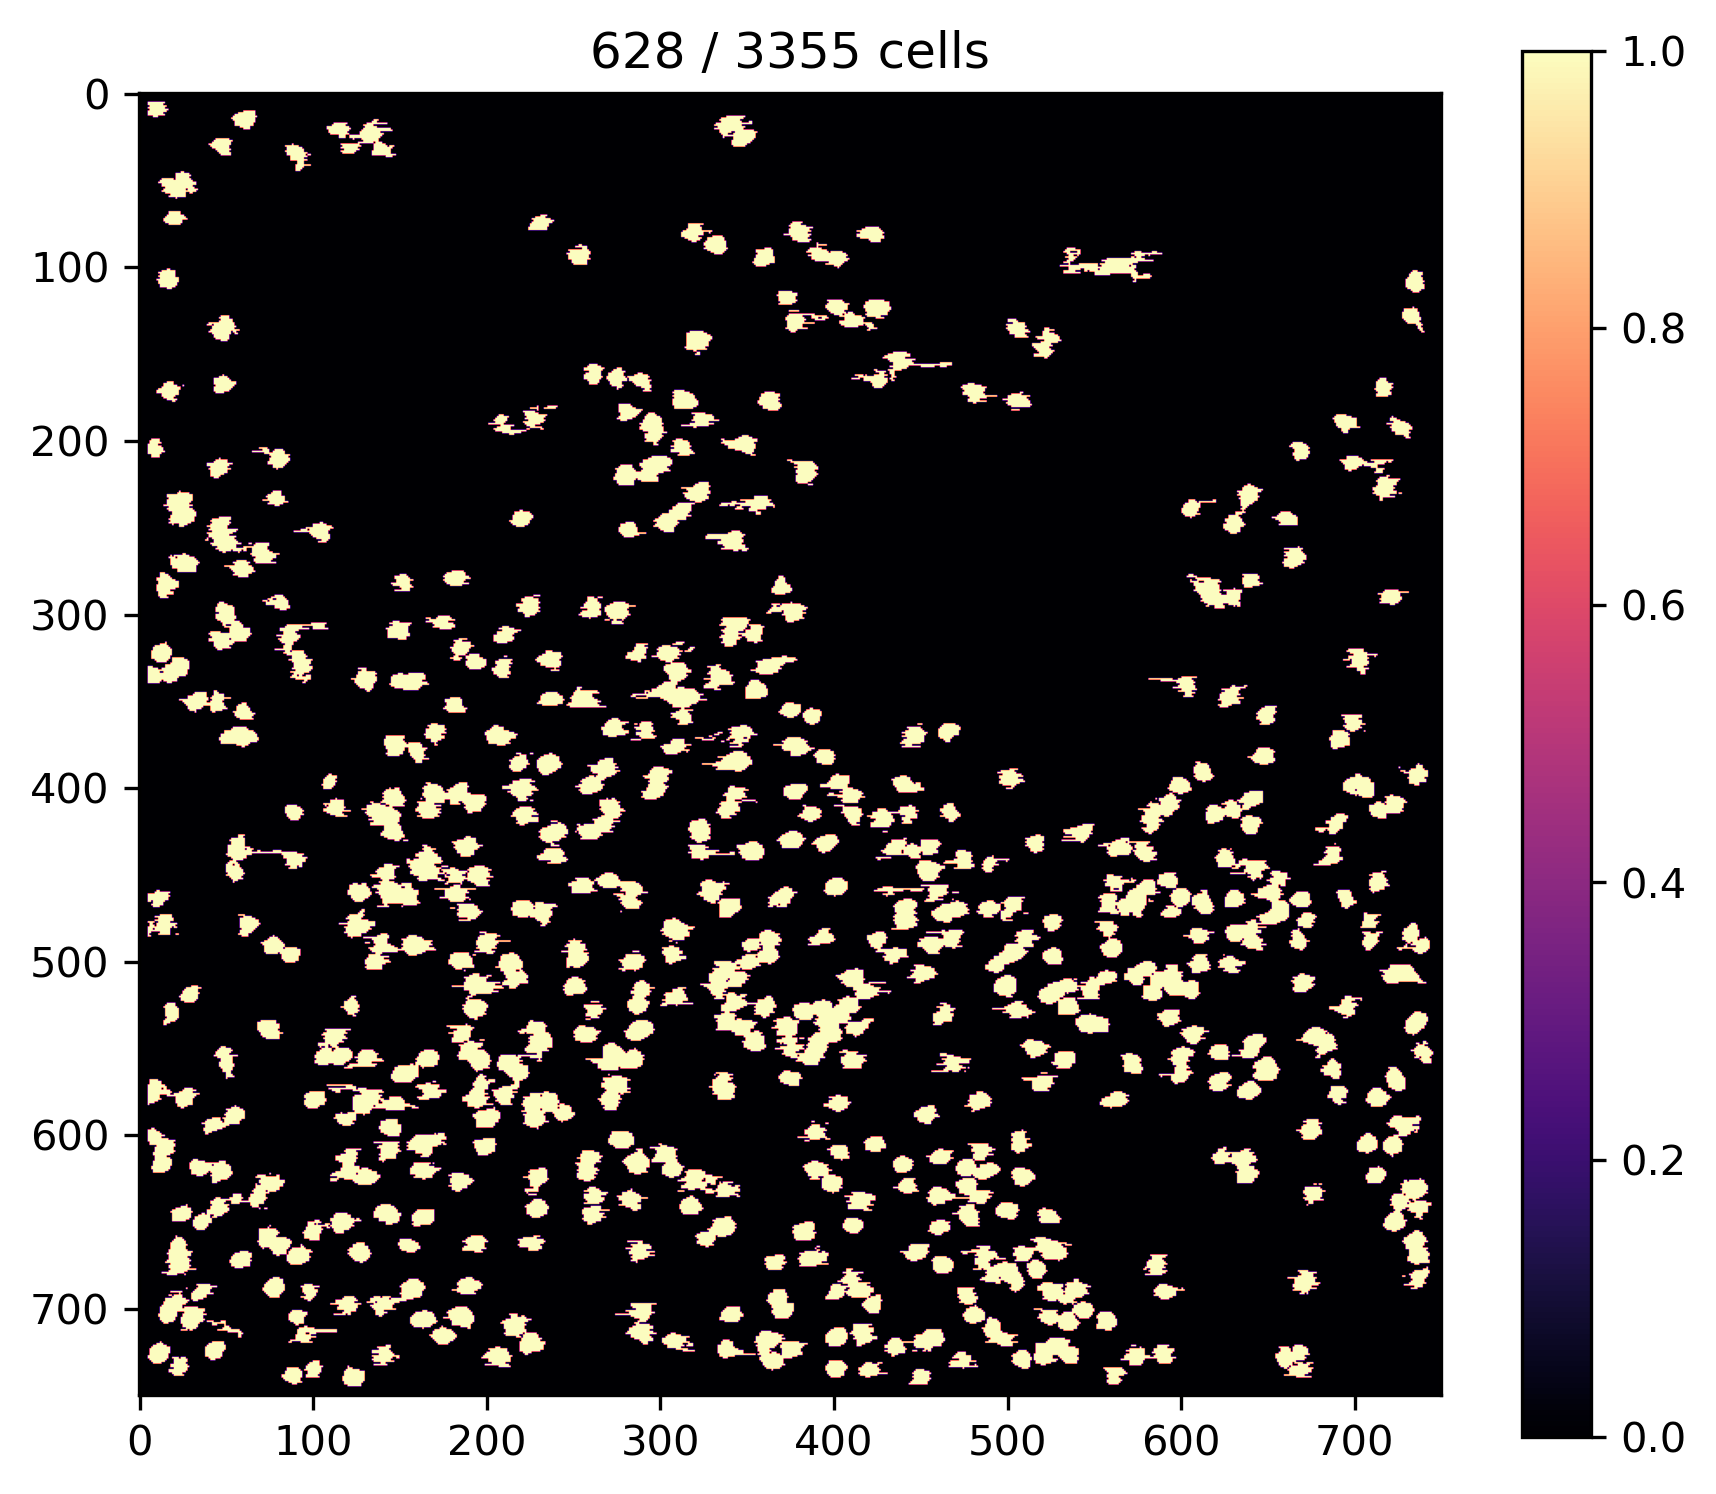

In [88]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(7,6))
_axim = ax.imshow(cell_mask, cmap='magma')
ax.set_title('{} / {} cells'.format(len(threshcells),
                                  len(data['stat'])))
plt.colorbar(_axim)

In [89]:
threshcells[:10]

array([104, 192, 240, 243, 267, 312, 346, 354, 369, 374])

In [16]:
import oasis

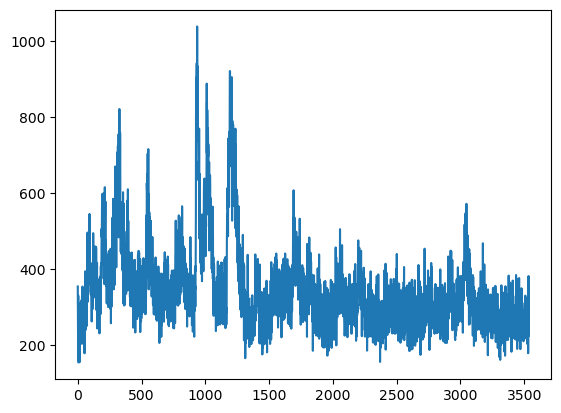

In [96]:
plt.plot(data['F'][369])

In [91]:
data['F0'][346]

269.22265625

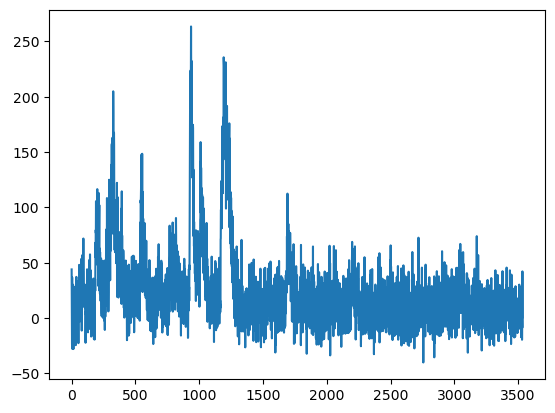

In [97]:
plt.plot(data['DFF'][369,:])

In [98]:
DFF = data['DFF'][369,:].copy()
g = oasis.functions.estimate_time_constant(DFF, 1)
_fluor_sig, _spikes = oasis.oasisAR1(DFF, g)

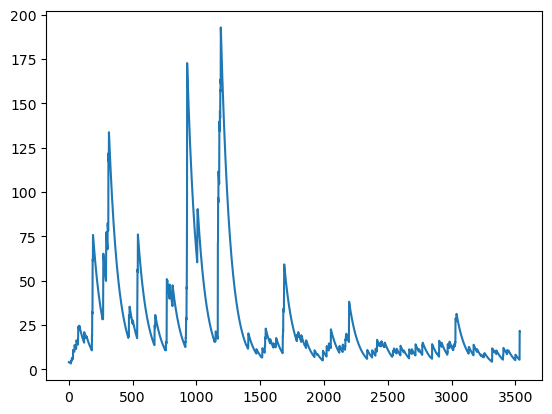

In [99]:
plt.plot(_fluor_sig)
# plt.xlim([0,300])

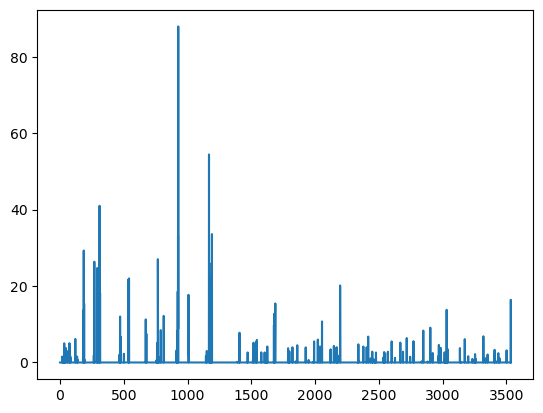

In [104]:
plt.plot(_spikes)
# plt.ylim([0,20])
# plt.xlim([0,50])

In [76]:
list(_spikes)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00010961433098458197,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00010421548243217811,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0008217676865394669,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00033377766486812534,
 0.0,
 0.0,
 0.0,
 0.0005831797366697244,
 0.0,
 0.0,
 0.0,
 0.0007150743244302732,
 6.902912931732461e-05,
 0.0,
 0.0,
 0.0005989277092847368,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0003992564877533071,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0024738201156416216,
 0.0006450897174412294,
 0.0006788279510698712,
 

In [105]:
0.7 exec('< 0.75')

SyntaxError: invalid syntax (3198485400.py, line 1)

In [116]:
print(eval("(0.7 > 0.75)"))

False


In [157]:
len(data['stat'][0]['lam'])

103

In [159]:
n = 0
stat = data['stat'].copy()
_arr = np.array([stat[n]['xpix'], stat[n]['ypix'], stat[n]['lam']])
np.shape(_arr)

(3, 103)

In [163]:
_arr[:,:10]

array([[725.        , 721.        , 722.        , 723.        ,
        724.        , 725.        , 726.        , 727.        ,
        719.        , 720.        ],
       [375.        , 376.        , 376.        , 376.        ,
        376.        , 376.        , 376.        , 376.        ,
        377.        , 377.        ],
       [  4.06868076,   6.60905838,  10.852952  ,  14.92269325,
         17.58154678,  17.21891785,  13.65961742,   8.31187057,
          5.86756468,  10.52867603]])

In [137]:
sorted(list(data['stat'][0].keys()))

['aspect_ratio',
 'compact',
 'footprint',
 'lam',
 'med',
 'mrs',
 'mrs0',
 'neuropil_mask',
 'npix',
 'npix_norm',
 'npix_norm_no_crop',
 'npix_soma',
 'overlap',
 'radius',
 'skew',
 'solidity',
 'soma_crop',
 'std',
 'xpix',
 'ypix']

In [150]:
for n in [1,2,3,4,5]:
    print(len(data['stat'][n]['ypix']) + len(data['stat'][n]['neuropil_mask']))

686
693
677
719
737


524